# Import Packages

In [85]:
import kagglehub
import pandas as pd
import os
from PIL import Image
import numpy as np
import torch 
from torch.utils.data import DataLoader, Dataset, random_split, ConcatDataset
import matplotlib.pyplot as plt
import seaborn as sns
import random
import torch.nn as nn
from torch.utils.data import DataLoader
import torchvision
from torchvision import transforms, models
import torch.optim.lr_scheduler as lrSched 
from sklearn.decomposition import PCA
from torchvision import models



# EDA


In [4]:
path = kagglehub.dataset_download("gpreda/chinese-mnist")

print("Path to dataset files:", path)

csv_file_path = f"{path}/chinese_mnist.csv"
dataDF = pd.read_csv(csv_file_path)


print("Feature names:", dataDF.columns.tolist())

Path to dataset files: /home/quiet98k/.cache/kagglehub/datasets/gpreda/chinese-mnist/versions/7
Feature names: ['suite_id', 'sample_id', 'code', 'value', 'character']


In [5]:
IMAGE_PATH = f"{path}/data/data/"
print("image files :", len(os.listdir(IMAGE_PATH)))

dataDF['file'] = dataDF[['suite_id','sample_id','code']].apply(lambda x: 'input_' + 
                 x['suite_id'].astype(str) +'_'+x['sample_id'].astype(str)+'_'+x['code'].astype(str)+'.jpg', axis=1)
dataDF.head(5)

characters = dataDF['character'].unique().tolist()
print(characters)
print(len(characters))

codes = dataDF['code'].unique().tolist()
print(codes)
print(len(codes))

dataDF.groupby(["code","character"]).size()

OUTPUT_SIZE = len(codes)

image files : 15000
['九', '十', '百', '千', '万', '亿', '零', '一', '二', '三', '四', '五', '六', '七', '八']
15
[10, 11, 12, 13, 14, 15, 1, 2, 3, 4, 5, 6, 7, 8, 9]
15


In [6]:
indexImage = 3000
imgPath =  os.path.join(IMAGE_PATH, dataDF['file'][indexImage]) 
im = Image.open(imgPath)
im.size
IMG_SIZE = im.size[0]

## Data Preparation

In [7]:
class ChineseMNISTdataset(Dataset):
    def __init__(self, annotations_dataframe, img_dir):
        self.df = annotations_dataframe
        self.img_dir = img_dir

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        imgPath =  os.path.join(self.img_dir, self.df ['file'][idx]) 
        img = Image.open(imgPath)

        imgAsT = torch.from_numpy(np.array(img)).float()

        label = self.df['code'][idx] -1 
        
        return imgAsT, label

In [8]:
chineseNumbers = ChineseMNISTdataset(dataDF, IMAGE_PATH)  
chineseNumbers.__len__() 

15000

torch.Size([64, 64])
9
15000


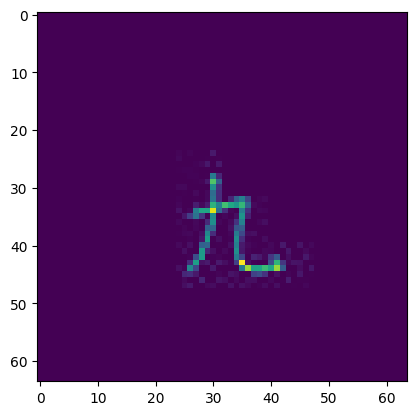

In [9]:
img, label = chineseNumbers.__getitem__(42)
print(img.shape)
print(label)
plt.imshow(img)
print(len(chineseNumbers))




## Split data for training and testing

In [10]:
SEED = 42

torch.manual_seed(SEED)
np.random.seed(SEED)

In [11]:
testSize = chineseNumbers.__len__() // 10
trainSize = chineseNumbers.__len__() - testSize

trainDataset, testDataset = random_split(chineseNumbers, [trainSize, testSize])

len(trainDataset), len(testDataset)

(13500, 1500)

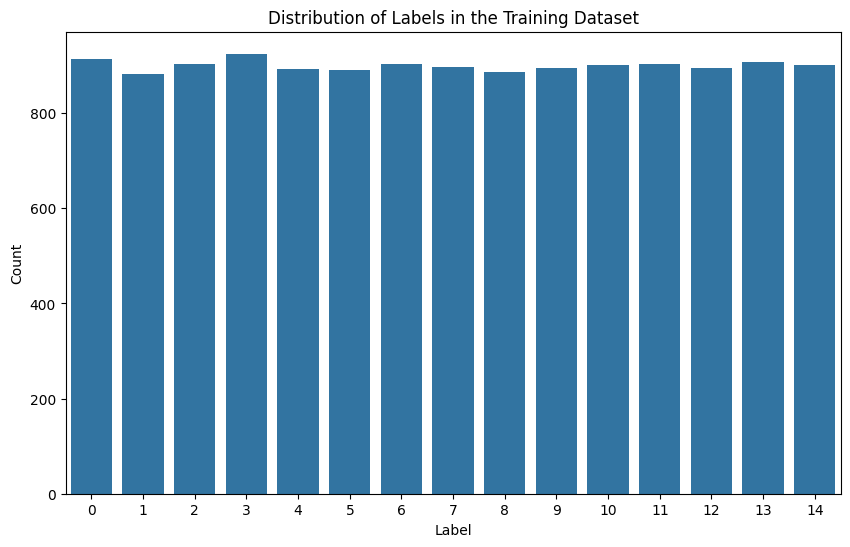

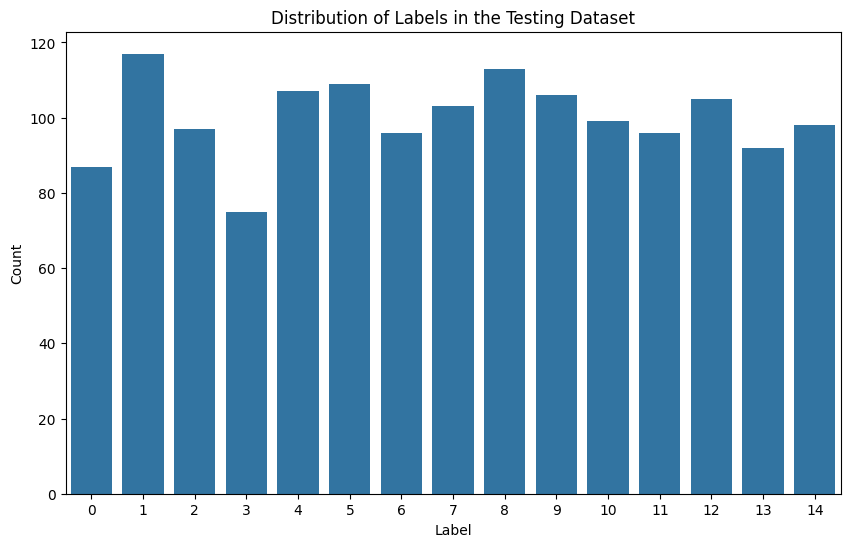

In [12]:
train_labels = [trainDataset[i][1] for i in range(len(trainDataset))]

train_labels_df = pd.DataFrame(train_labels, columns=['label'])

test_labels = [testDataset[i][1] for i in range(len(testDataset))]

test_labels_df = pd.DataFrame(test_labels, columns=['label'])

plt.figure(figsize=(10, 6))
sns.countplot(x='label', data=train_labels_df)
plt.title('Distribution of Labels in the Training Dataset')
plt.xlabel('Label')
plt.ylabel('Count')
plt.show()

plt.figure(figsize=(10, 6))
sns.countplot(x='label', data=test_labels_df)
plt.title('Distribution of Labels in the Testing Dataset')
plt.xlabel('Label')
plt.ylabel('Count')
plt.show()

In [13]:
labels_dict = {
     0: "0", 1: "1", 2: "2", 3: "3", 4: "4", 5: "5",
     6: "6", 7: "7", 8: "8", 9: "9", 10: "10",
     11: "100", 12: "1000", 13: "10,000", 14: "1,000,000"
 }


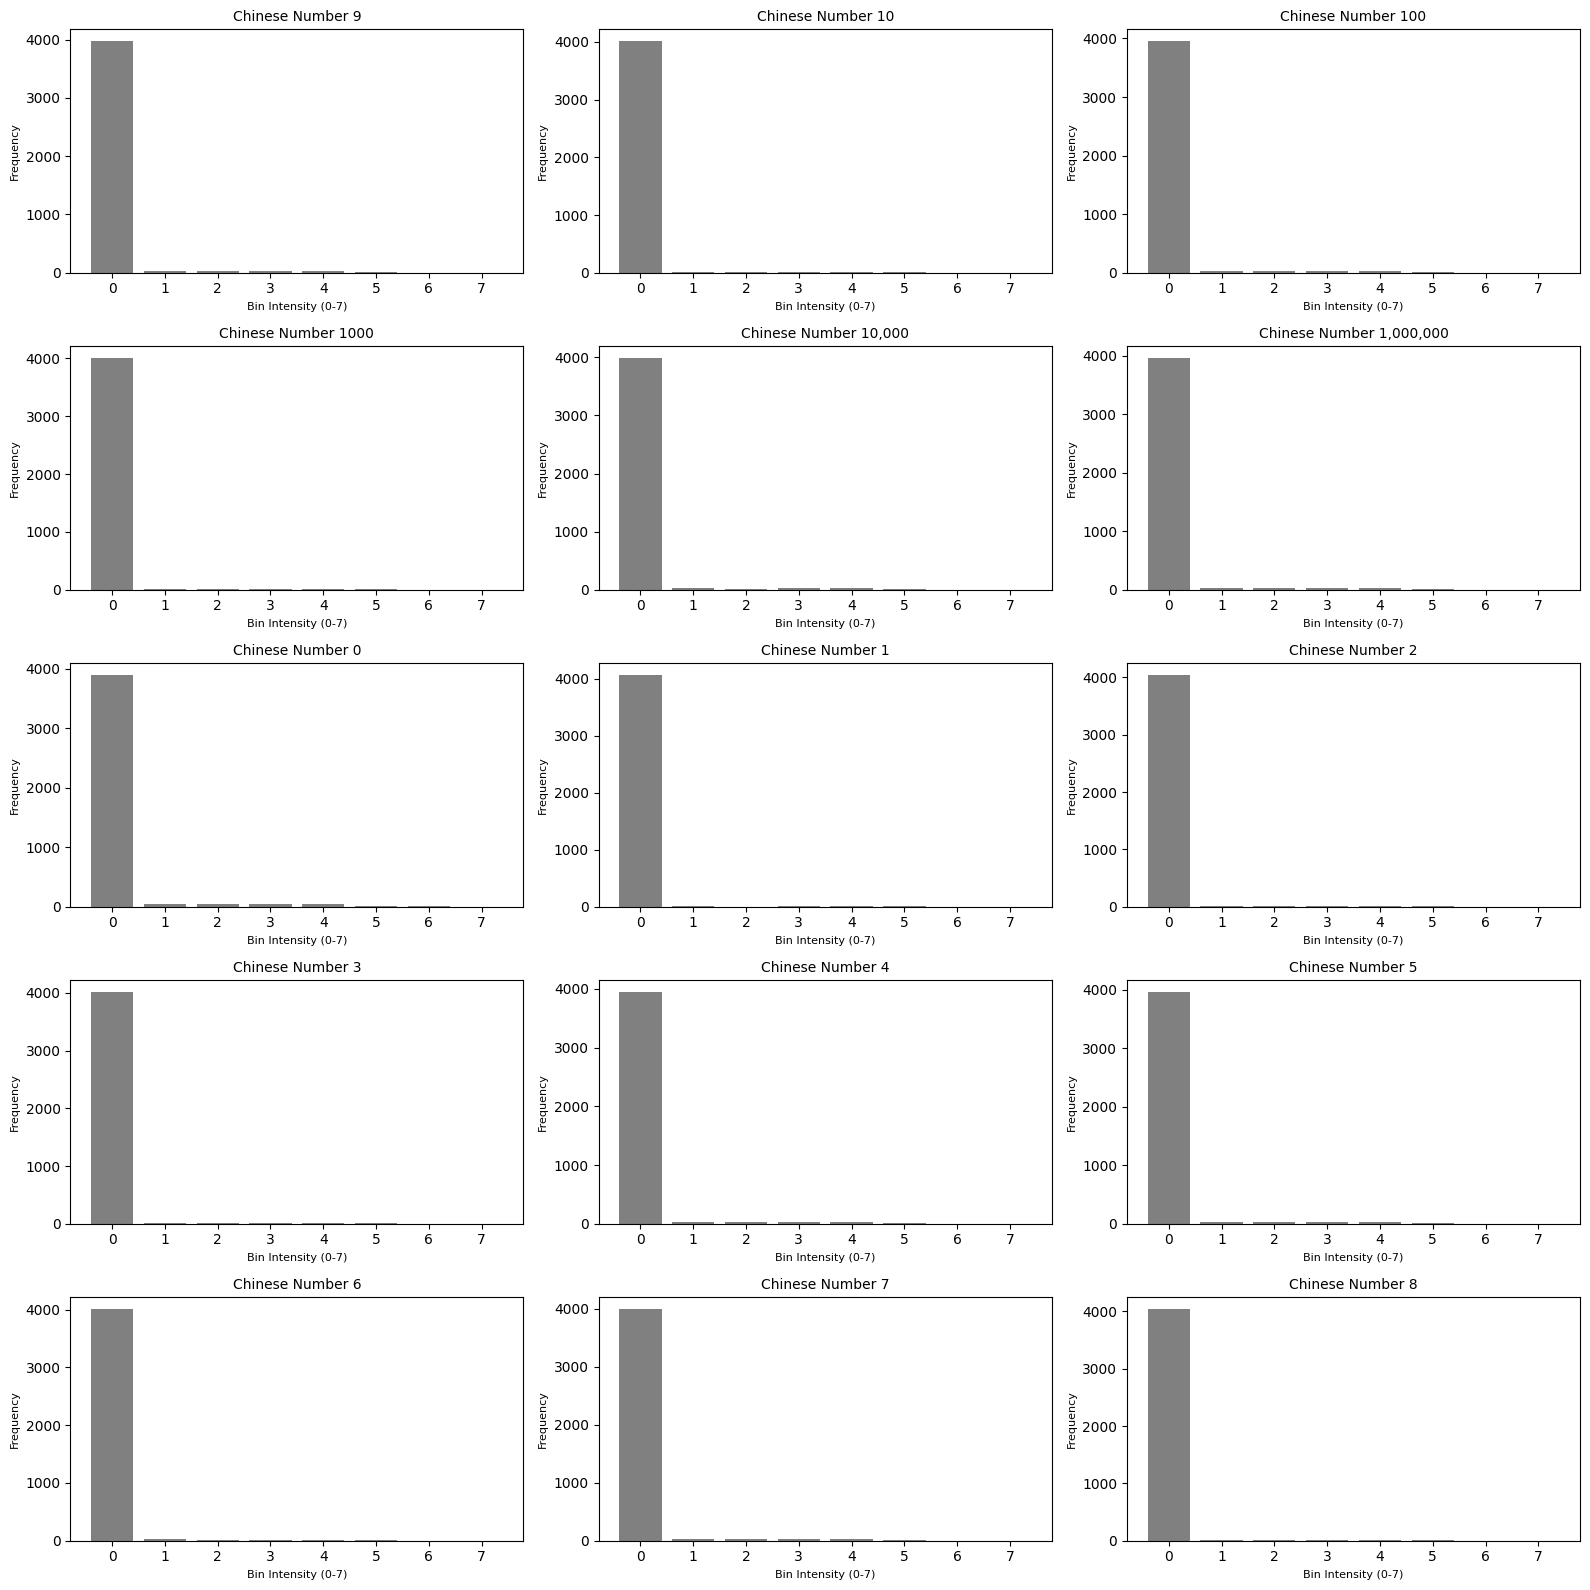

In [14]:
import matplotlib.pyplot as plt
import numpy as np

rows = 5
cols = 3 
fig, axes = plt.subplots(rows, cols, figsize=(16, 16))  
axes = axes.flatten()  

for idx, i in enumerate(range(0, 15000, 1000)):
    if idx >= len(axes):  
        break

    accumulated_hist = np.zeros(8)

    
    for j in range(i, i + 10):
        img, label = chineseNumbers.__getitem__(j)  

        img_array = img.flatten()  

        hist, _ = np.histogram(img_array, bins=8, range=(0, 256))
        accumulated_hist += hist / 10  

    axes[idx].bar(range(8), accumulated_hist, color='gray', tick_label=range(8))
    axes[idx].set_xlabel('Bin Intensity (0-7)', fontsize=8)
    axes[idx].set_ylabel('Frequency', fontsize=8)
    axes[idx].set_title(f'Chinese Number {labels_dict[label]}', fontsize=10)

for idx in range(len(axes)):
    if idx >= (15000 // 1000):  
        axes[idx].axis('off')  

plt.tight_layout()
plt.show()


## Sharpness and Edge Detection
- **Objective**: To detect inconsistencies in stroke sharpness and identify blurry or low-quality scans.
- **How**: Apply edge detection filters (such as Sobel or Canny) across a random subset of images. Calculate edge sharpness metrics, and examine if there’s a wide variance in edge clarity.
- **Outcome**: Reveals if any images may need filtering or quality adjustments to standardize sharpness, ensuring the model doesn’t learn unintended noise.

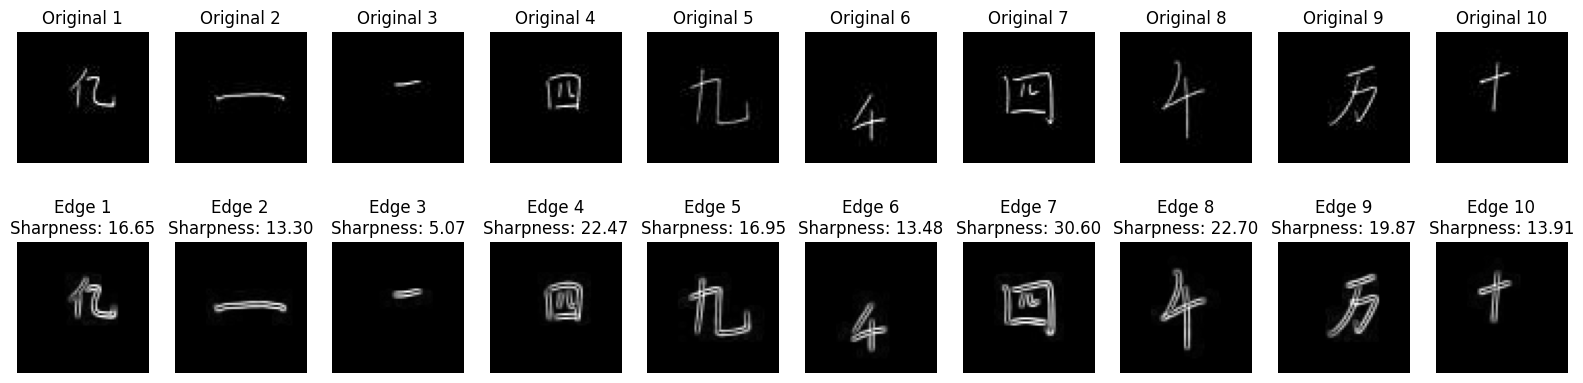

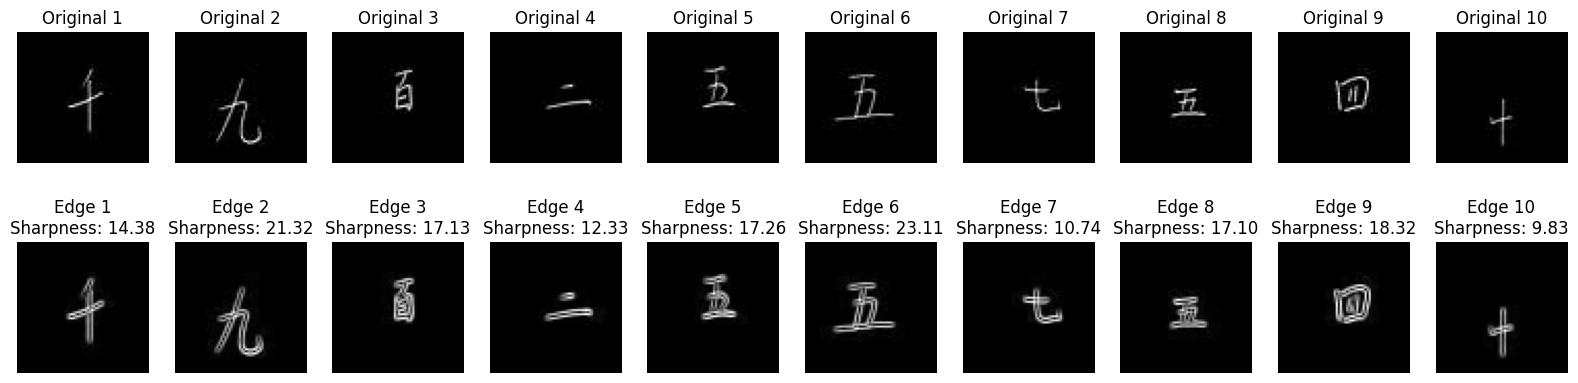

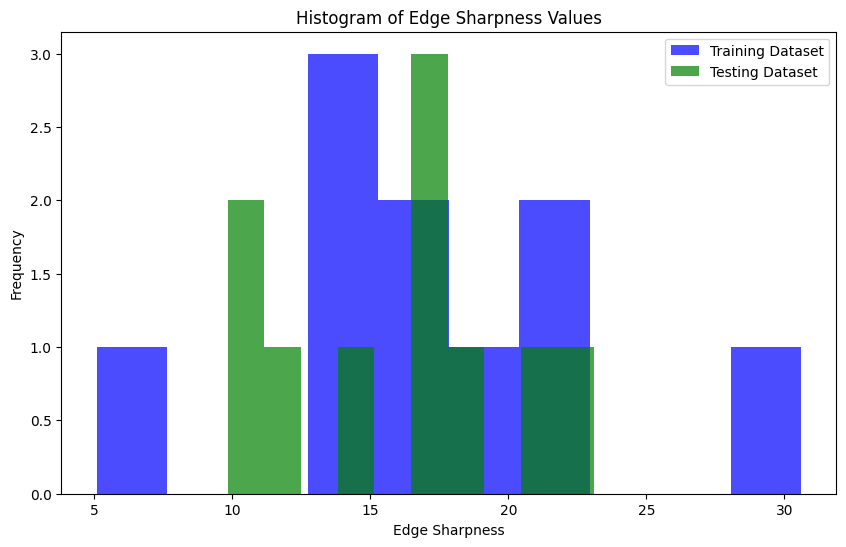

In [15]:
from scipy.ndimage import sobel



def calculate_edge_sharpness(image):
    sobel_x = sobel(image, axis=0)
    sobel_y = sobel(image, axis=1)
    edge_magnitude = np.hypot(sobel_x, sobel_y)
    return np.mean(edge_magnitude)

def visualize_edge_detection(dataset, num_samples=10):
    indices = random.sample(range(len(dataset)), num_samples)
    fig, axes = plt.subplots(2, num_samples, figsize=(20, 5))
    
    sharpness_values = []
    
    for i, idx in enumerate(indices):
        img, _ = dataset[idx]
        img_np = img.numpy()
        
        sharpness = calculate_edge_sharpness(img_np)
        sharpness_values.append(sharpness)
        
        axes[0, i].imshow(img_np, cmap='gray')
        axes[0, i].axis('off')
        axes[0, i].set_title(f'Original {i+1}')
        
        sobel_x = sobel(img_np, axis=0)
        sobel_y = sobel(img_np, axis=1)
        edge_magnitude = np.hypot(sobel_x, sobel_y)
        axes[1, i].imshow(edge_magnitude, cmap='gray')
        axes[1, i].axis('off')
        axes[1, i].set_title(f'Edge {i+1}\nSharpness: {sharpness:.2f}')
    
    plt.show()
    
    return sharpness_values

train_sharpness_values = visualize_edge_detection(trainDataset)

test_sharpness_values = visualize_edge_detection(testDataset)

plt.figure(figsize=(10, 6))
plt.hist(train_sharpness_values, bins=10, color='blue', alpha=0.7, label='Training Dataset')
plt.hist(test_sharpness_values, bins=10, color='green', alpha=0.7, label='Testing Dataset')
plt.title('Histogram of Edge Sharpness Values')
plt.xlabel('Edge Sharpness')
plt.ylabel('Frequency')
plt.legend()
plt.show()

## Intra-Character Consistency Check
- **Objective**: To examine the consistency of each character’s appearance across different samples and volunteers.
- **How**: Calculate the mean and standard deviation of pixel intensities for each character across all samples, visualizing the range to observe consistency. You might also create "mean" images for each character by averaging pixel values across all samples of a character.
- **Outcome**: This shows the typical appearance of each character and helps in understanding how much variation exists within the same character, which is useful for designing augmentations.

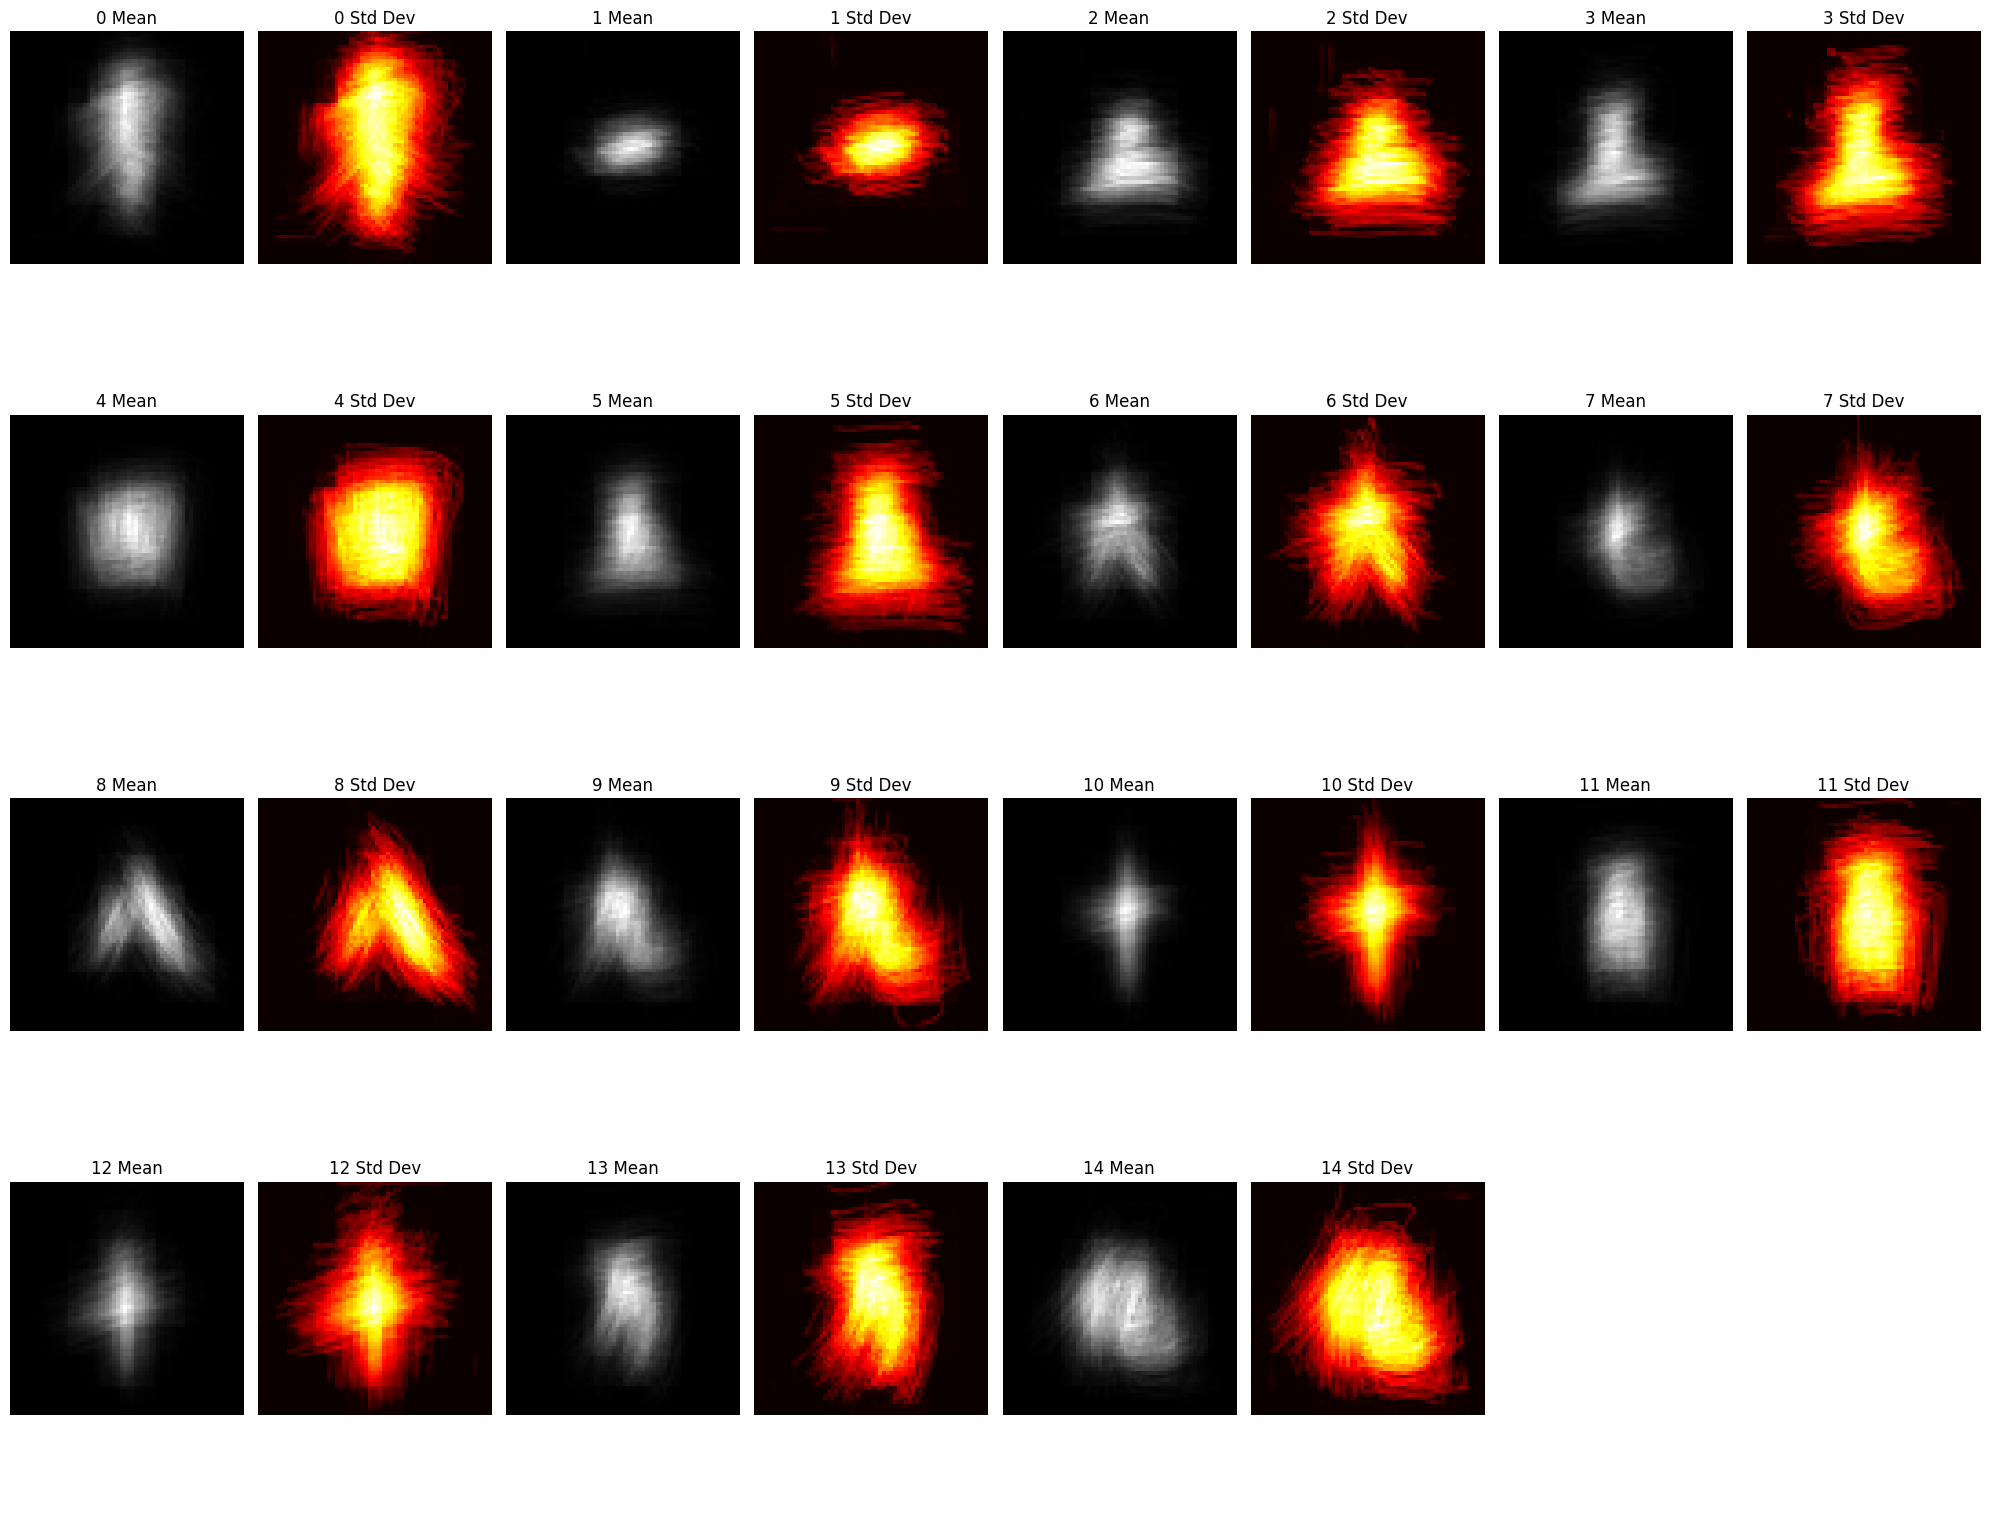

In [16]:

mean_images = []
st_dev_images = []
titles = []

for character in range(len(characters)):
    character_img = []

    for i in range(len(trainDataset)):
        img, label = trainDataset[i]
        if label == character:
            character_img.append(img.numpy())

    if len(character_img) == 0:
        print(f"No images found for character {character}")
        continue

    character_img = np.array(character_img)

    mean_image = np.mean(character_img, axis=0)
    st_dev_image = np.std(character_img, axis=0)

    mean_images.append(mean_image)
    st_dev_images.append(st_dev_image)
    titles.append(f"{character} Mean")
    titles.append(f"{character} Std Dev")


num_images = len(mean_images) + len(st_dev_images)
cols = 8  
rows = (num_images + cols - 1) // cols
fig, axes = plt.subplots(rows, cols, figsize=(20, rows * 4))
axes = axes.ravel()

for i, ax in enumerate(axes):
    if i < len(titles):
        if i % 2 == 0:
            ax.imshow(mean_images[i // 2], cmap='gray')
        else:
            ax.imshow(st_dev_images[i // 2], cmap='hot')
        ax.set_title(titles[i])
        ax.axis('off')
    else:
        ax.axis('off')  

plt.tight_layout()
plt.show()

# Data Preparation

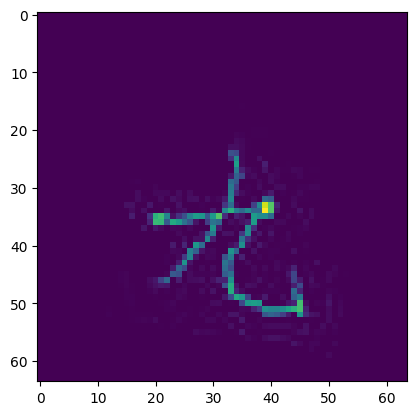

In [55]:

img, label = chineseNumbers.__getitem__(123)
plt.imshow(img)
img_pil = Image.fromarray(img.numpy().astype(np.uint8))
random_rotation = transforms.RandomRotation(degrees=(-30, 30))
rotated_img = random_rotation(img_pil)
plt.imshow(rotated_img)


## Character Pattern Analysis Using PCA
Objective: To identify structural patterns in characters and see if they’re distinguishable based on strokes and shapes.
How: Flatten each image and apply Principal Component Analysis (PCA) on these flattened images for each character. Plot the first two principal components to visualize common patterns or traits within each character class.
Outcome: This helps uncover distinctive patterns or shapes for each character, providing insights into feature extraction needs for classification.



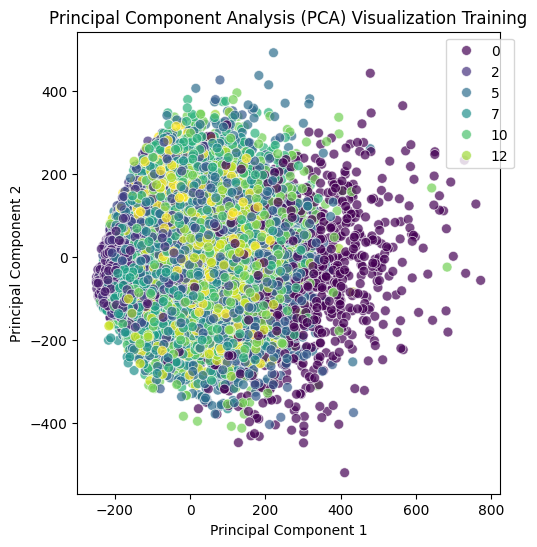

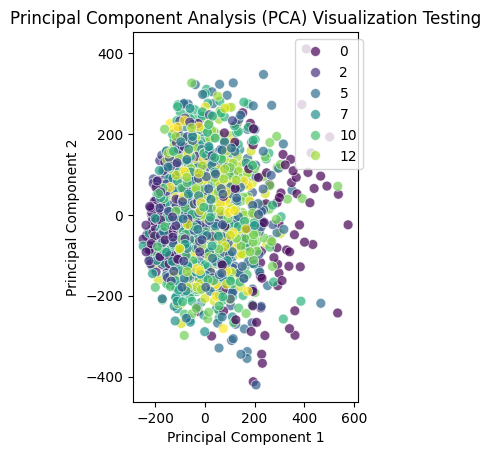

<Figure size 640x480 with 0 Axes>

In [56]:
def load_and_flatten_images(dataset):
  flattened_images = []
  labels = []

  for i in range(len(dataset)):
    img, label = dataset[i]
    img_np = img.numpy().flatten()
    flattened_images.append(img_np)
    labels.append(label)

  return np.array(flattened_images), np.array(labels)

train_flattened_images, labels = load_and_flatten_images(trainDataset)
test_flattened_images, _ = load_and_flatten_images(testDataset)

pca = PCA(n_components=2)
train_principal_components = pca.fit_transform(train_flattened_images)
test_principal_components = pca.transform(test_flattened_images)

train_pca_df = pd.DataFrame({
    'PC1': train_principal_components[:, 0],
    'PC2': train_principal_components[:, 1],
    'Label': train_labels
})

test_pca_df = pd.DataFrame({
    'PC1': test_principal_components[:, 0],
    'PC2': test_principal_components[:, 1],
    'Label': test_labels
})


plt.figure(figsize=(12, 6))

plt.subplot(1,2,1)
sns.scatterplot(data=train_pca_df, x='PC1', y='PC2', hue='Label', palette='viridis', s= 50, alpha = 0.7)
plt.title('Principal Component Analysis (PCA) Visualization Training')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper right')
plt.show()

plt.subplot(1,2,2)
sns.scatterplot(data=test_pca_df, x='PC1', y='PC2', hue='Label', palette='viridis', s= 50, alpha = 0.7)
plt.title('Principal Component Analysis (PCA) Visualization Testing')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper right')
plt.show()

plt.tight_layout()
plt.show()


## Augmentation Preview for Quality Assurance

- **Objective**: To assess the effect of augmentations on image quality and character integrity.
- **How**: Apply planned augmentations (rotations, scaling, translations) on a sample set of images and visually inspect them in a grid format for each character.
- **Outcome**: Ensures that augmentations preserve the integrity of each character, helping validate that these transformations won’t create distortions or unnatural examples for the model.


27000
3000
Combined Train Dataset - Sample 0: Image shape: torch.Size([1, 64, 64]), Label: 5
Combined Train Dataset - Sample 1: Image shape: torch.Size([1, 64, 64]), Label: 13
Combined Train Dataset - Sample 2: Image shape: torch.Size([1, 64, 64]), Label: 12
Combined Train Dataset - Sample 3: Image shape: torch.Size([1, 64, 64]), Label: 2
Combined Train Dataset - Sample 4: Image shape: torch.Size([1, 64, 64]), Label: 13
Combined Test Dataset - Sample 0: Image shape: torch.Size([1, 64, 64]), Label: 8
Combined Test Dataset - Sample 1: Image shape: torch.Size([1, 64, 64]), Label: 8
Combined Test Dataset - Sample 2: Image shape: torch.Size([1, 64, 64]), Label: 14
Combined Test Dataset - Sample 3: Image shape: torch.Size([1, 64, 64]), Label: 9
Combined Test Dataset - Sample 4: Image shape: torch.Size([1, 64, 64]), Label: 10


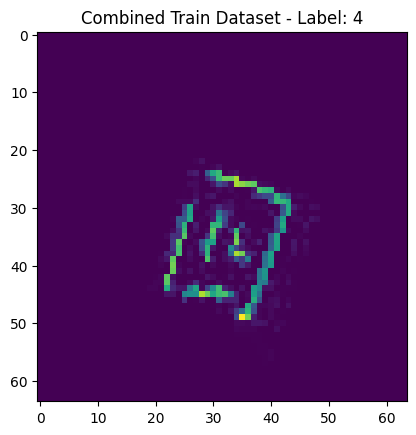

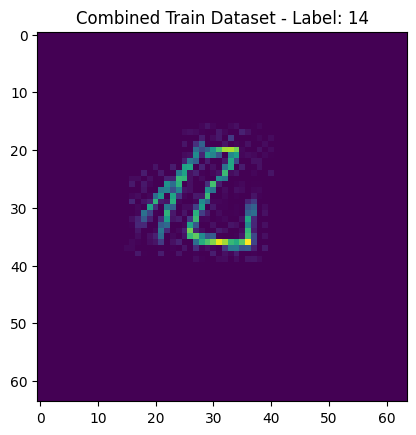

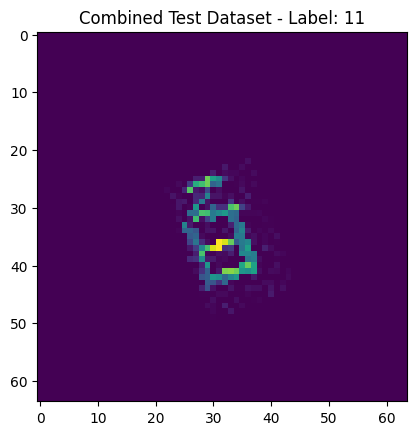

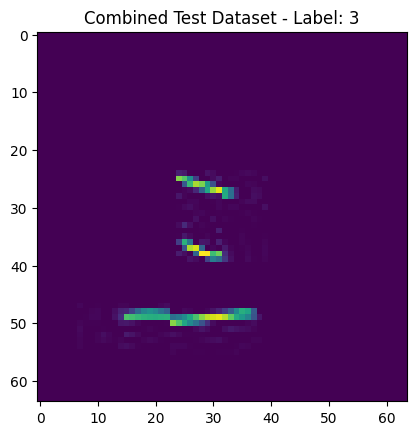

In [57]:
class AugmentedDataset(Dataset):
    def __init__(self, images, labels):
        self.images = images
        self.labels = labels

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        return self.images[idx], self.labels[idx]

def random_rotation(image):
    angle = random.uniform(-30, 30)  
    return image.rotate(angle)

augmented_images_train = []
augmented_labels_train = []
augmented_images_test = []
augmented_labels_test = []

train_images_tensor = [transforms.ToTensor()(Image.fromarray(img.numpy().astype(np.uint8))) for img, _ in trainDataset]
test_images_tensor = [transforms.ToTensor()(Image.fromarray(img.numpy().astype(np.uint8))) for img, _ in testDataset]

for img, label in trainDataset:
    img_pil = Image.fromarray(img.numpy().astype(np.uint8))
    rotated_img = random_rotation(img_pil)
    rotated_img_tensor = transforms.ToTensor()(rotated_img)
    augmented_images_train.append(rotated_img_tensor)
    augmented_labels_train.append(label)

for img, label in testDataset:
    img_pil = Image.fromarray(img.numpy().astype(np.uint8))
    rotated_img = random_rotation(img_pil)
    rotated_img_tensor = transforms.ToTensor()(rotated_img)
    augmented_images_test.append(rotated_img_tensor)
    augmented_labels_test.append(label)

augmented_trainDataset = AugmentedDataset(augmented_images_train, augmented_labels_train)
augmented_testDataset = AugmentedDataset(augmented_images_test, augmented_labels_test)

combined_trainDataset = ConcatDataset([AugmentedDataset(train_images_tensor, [label for _, label in trainDataset]), augmented_trainDataset])
combined_testDataset = ConcatDataset([AugmentedDataset(test_images_tensor, [label for _, label in testDataset]), augmented_testDataset])

print(len(combined_trainDataset))
print(len(combined_testDataset))

def check_dataset_consistency(dataset, name):
    for i in range(5):  
        img, label = dataset[random.randint(0, len(dataset) - 1)]
        print(f"{name} - Sample {i}: Image shape: {img.shape}, Label: {label}")

check_dataset_consistency(combined_trainDataset, "Combined Train Dataset")
check_dataset_consistency(combined_testDataset, "Combined Test Dataset")

def visualize_samples(dataset, name):
    for i in range(2):  
        img, label = dataset[random.randint(0, len(dataset) - 1)]
        plt.imshow(transforms.ToPILImage()(img))
        plt.title(f"{name} - Label: {label}")
        plt.show()

visualize_samples(combined_trainDataset, "Combined Train Dataset")
visualize_samples(combined_testDataset, "Combined Test Dataset")

# Model Implementation
## VGG-16
### Define a data loader

### Define CNN model

In [20]:

class VGG16(nn.Module):
    def __init__(self, dropout_rate=0.5):
        super(VGG16, self).__init__()
        
        self.features = nn.Sequential(
            nn.Conv2d(1, 64, kernel_size=3, padding=1),  
            nn.BatchNorm2d(64),  
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),  
            
            nn.Conv2d(64, 128, kernel_size=3, padding=1),  
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            
            nn.Conv2d(128, 256, kernel_size=3, padding=1),  
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            
            nn.Conv2d(256, 512, kernel_size=3, padding=1), 
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            
            nn.Conv2d(512, 512, kernel_size=3, padding=1),  
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )
        
        self.classifier = nn.Sequential(
            nn.Linear(512 * 2 * 2, 4096),  
            nn.ReLU(inplace=True),
            nn.Dropout(p=dropout_rate),  
            
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(p=dropout_rate),
            
            nn.Linear(4096, 15)  
        )
        
        self._initialize_weights()
    
    def forward(self, x):
        x = self.features(x)  
        x = x.view(x.size(0), -1)  
        x = self.classifier(x)  
        return x
    
    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, 0, 0.01)
                nn.init.constant_(m.bias, 0)

In [21]:
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

simpleModel = VGG16().to(device)
print("The model: ", simpleModel)

params = list(simpleModel.parameters())
len(params)

num_params = sum(p.numel() for p in simpleModel.parameters() if p.requires_grad)
print("Total number of trainable model parameters:", num_params)

Using cuda device
The model:  VGG16(
  (features): Sequential(
    (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU(inplace=True)
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU(inplace=True)
    (11): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (12): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (13): ReLU(inpl

### Train the model

In [22]:
import itertools
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader

hyperparams = {
    'dropout_rate': [0.3, 0.5],          
    'optimizer': ['SGD', 'Adam'],        
    'learning_rate': [0.001, 0.01],      
    'batch_size': [32, 64],              
    'num_epochs': [20, 40],              
    'regularization': [0.0001, 0.001]    
}

grid = list(itertools.product(*hyperparams.values()))

results = []

trainLoader = DataLoader(combined_trainDataset, batch_size=64, shuffle=True)
testLoader = DataLoader(combined_testDataset, batch_size=64, shuffle=False)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

def train_and_evaluate(params):
    dropout_rate, opt_type, lr, batch_size, num_epochs, reg = params

    trainLoader = DataLoader(combined_trainDataset, batch_size=batch_size, shuffle=True)
    testLoader = DataLoader(combined_testDataset, batch_size=batch_size, shuffle=False)

    model = VGG16(dropout_rate=dropout_rate)
    model.to(device)

    criterion = nn.CrossEntropyLoss()

    if opt_type == 'SGD':
        optimizer = optim.SGD(model.parameters(), lr=lr, weight_decay=reg)  
    elif opt_type == 'Adam':
        optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=reg)  

    loss_history = []

    for epoch in range(num_epochs):
        model.train()
        epoch_loss = 0
        correct = 0
        total = 0

        for X, y in trainLoader:
            X, y = X.to(device), y.to(device)

            logits = model(X)
            loss = criterion(logits, y)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            epoch_loss += loss.item()
            preds = torch.argmax(logits, dim=1)
            correct += (preds == y).sum().item()
            total += y.size(0)

        loss_history.append(epoch_loss / len(trainLoader))

        model.eval()
        val_correct = 0
        val_total = 0
        with torch.no_grad():
            for X_val, y_val in testLoader:
                X_val, y_val = X_val.to(device), y_val.to(device)
                val_logits = model(X_val)
                val_preds = torch.argmax(val_logits, dim=1)
                val_correct += (val_preds == y_val).sum().item()
                val_total += y_val.size(0)

        val_accuracy = val_correct / val_total
        print(f"Epoch [{epoch+1}/{num_epochs}] Loss: {epoch_loss:.4f} | Val Accuracy: {val_accuracy:.4f}")
    torch.save(model.state_dict(), 'vgg_16_model.pth')
    
    return val_accuracy, loss_history, model  




In [ ]:
for i, params in enumerate(grid):
    param_dict = dict(zip(hyperparams.keys(), params))  
    print(f"Testing combination {i + 1}/{len(grid)}: ", end="")
    for param_name, param_value in param_dict.items():
        print(f"{param_name}: {param_value}", end=", ")
    print()  
    val_acc, loss_history = train_and_evaluate(params)
    results.append((params, val_acc, loss_history))

best_params, best_acc, _ = max(results, key=lambda x: x[1])
print(f"Best Parameters: {best_params}")
print(f"Best Validation Accuracy: {best_acc:.4f}")

for i, (params, val_acc, loss_history) in enumerate(results):
    print(f"Combination {i + 1}: {dict(zip(hyperparams.keys(), params))}")
    print(f"Validation Accuracy: {val_acc:.4f}")
    print(f"Loss History: {loss_history}")

In [ ]:
best_param = (0.5, 'SGD', 0.01, 32, 40, 0.0001)
acc, hist, best_model = train_and_evaluate(best_param)

In [ ]:
plt.plot(hist)
plt.xlabel('Epoch')
plt.ylabel('loss')
plt.title('Loss vs. No. of epochs')
plt.show()

### Simple Testing

In [ ]:

import torch
import torch.nn as nn
import torchvision.models as models
import matplotlib.pyplot as plt
from torchvision import transforms

def test_single_image(model, image, image_label, device):
    model.eval()
    
    image = image.to(device)
    model = model.to(device)
    
    if len(image.shape) == 3:  
        image = image.unsqueeze(0)  
    
    with torch.no_grad():
        logits = model(image)  
        pred_label = torch.argmax(logits, dim=1).item()  

    is_correct = pred_label == image_label
    
    return pred_label, is_correct

testImg, testLabel = combined_testDataset[97]
print(testLabel)
plt.imshow(transforms.ToPILImage()(testImg))
test_single_image(best_model, testImg, testLabel, device)

## LeNet
### Define model

In [23]:
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

class LeNet(nn.Module):
    def __init__(self, num_classes=15, dropout_rate=0.5):
        super(LeNet, self).__init__()
        
        self.conv1 = nn.Conv2d(1, 6, kernel_size=5)  
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)  
        
        self.conv2 = nn.Conv2d(6, 16, kernel_size=5)  
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)  
        
        self.flattened_size = 16 * 13 * 13  
        
        self.fc1 = nn.Linear(self.flattened_size, 120)  
        self.dropout1 = nn.Dropout(p=dropout_rate)  

        self.fc2 = nn.Linear(120, 84)  
        self.dropout2 = nn.Dropout(p=dropout_rate)  

        self.fc3 = nn.Linear(84, num_classes)  
    
    def forward(self, x):
        x = F.relu(self.conv1(x))  
        x = self.pool1(x)
        
        x = F.relu(self.conv2(x))  
        x = self.pool2(x)
        
        x = x.view(x.size(0), -1)
        
        x = F.relu(self.fc1(x))  
        x = self.dropout1(x)

        x = F.relu(self.fc2(x))  
        x = self.dropout2(x)

        x = self.fc3(x)  
        
        return x

param_grid = {
    'learning_rate': [0.001, 0.01],
    'batch_size': [64, 256],
    'dropout_rate': [0.3, 0.5],
    'optimizer': ['sgd', 'adam'],
    'num_epochs': [20, 40]
}


### Train model

In [ ]:
from sklearn.model_selection import ParameterGrid

def train_model(train_loader, model, criterion, optimizer, num_epochs):
    loss_history = []  

    for epoch in range(num_epochs):
        model.train()
        epoch_loss = 0

        for X, y in train_loader:
            X, y = X.to(device), y.to(device)

            logits = model(X)
            loss = criterion(logits, y)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            epoch_loss += loss.item()
            preds = torch.argmax(logits, dim=1)

        loss_history.append(epoch_loss / len(train_loader))
        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss}")

    return loss_history

def evaluate_model(test_loader, model):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    
    accuracy = 100 * correct / total
    print(f"Test Accuracy: {accuracy}%")
    return accuracy

def grid_search(param_grid):
    best_accuracy = 0.0
    best_params = None
    
    grid = ParameterGrid(param_grid)
    
    for params in grid:
        print(f"Training with params: {params}")
        
        model = LeNet(dropout_rate=params['dropout_rate']).to(device)
        criterion = nn.CrossEntropyLoss()
        if params['optimizer'] == 'adam':
            optimizer = optim.Adam(model.parameters(), lr=params['learning_rate'])
        elif params['optimizer'] == 'sgd':
            optimizer = optim.SGD(model.parameters(), lr=params['learning_rate'], momentum=0.99)
        
        train_loader = DataLoader(combined_trainDataset, batch_size=params['batch_size'], shuffle=True)
        test_loader = DataLoader(combined_testDataset, batch_size=params['batch_size'], shuffle=False)
        
        loss_history = train_model(train_loader, model, criterion, optimizer, params['num_epochs'])
        
        accuracy = evaluate_model(test_loader, model)
        
        if accuracy > best_accuracy:
            best_accuracy = accuracy
            best_params = params
            best_loss_history = loss_history
    
    print(f"Best accuracy: {best_accuracy}% with parameters: {best_params}")
    return best_params, best_accuracy, best_loss_history

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

best_params, best_accuracy, best_loss_history = grid_search(param_grid)

In [ ]:
# Best accuracy: 96.63333333333334% with parameters: {'batch_size': 64, 'dropout_rate': 0.3, 'learning_rate': 0.001, 'num_epochs': 40, 'optimizer': 'sgd'}
# Best accuracy: 95.2% with parameters: {'batch_size': 256, 'dropout_rate': 0.3, 'learning_rate': 0.01, 'num_epochs': 40, 'optimizer': 'adam'}
train_loader = DataLoader(combined_trainDataset, batch_size=64, shuffle=True)
test_loader = DataLoader(combined_testDataset, batch_size=64, shuffle=False)

model = LeNet(dropout_rate=0.3).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.99)
#optimizer = optim.Adam(model.parameters(), lr=0.01)

loss_history = train_model(train_loader, model, criterion, optimizer, num_epochs=40)

accuracy = evaluate_model(test_loader, model)

print(f"Test Accuracy: {accuracy}%")
torch.save(model.state_dict(), 'lenet_model.pth')

In [ ]:
plt.plot(loss_history)
plt.xlabel('Epoch')
plt.ylabel('loss')
plt.title('Loss over epochs')
plt.show()

## Resnet


In [48]:
import itertools
import torch
import torch.nn as nn
from torch.utils.data import DataLoader


In [49]:
param_grid = {
    'learning_rate': [0.001, 0.01],
    'batch_size': [64, 128],
    'dropout_rate': [0, 0.3, 0.5],
    'optimizer': ['sgd', 'adam'],
    'num_epochs': [20, 40],
    'input_size': [64, 128]  
}

param_combinations = list(itertools.product(
    param_grid['learning_rate'],
    param_grid['batch_size'],
    param_grid['dropout_rate'],
    param_grid['optimizer'],
    param_grid['num_epochs'],
    param_grid['input_size']
))


In [59]:
class ResNetWithDropout(nn.Module):
    def __init__(self, dropout_rate, num_classes=10, input_channels=3):
        super(ResNetWithDropout, self).__init__()
        self.resnet = models.resnet18(weights=None)
        
        if input_channels != 3:
            self.resnet.conv1 = nn.Conv2d(
                input_channels,
                self.resnet.conv1.out_channels,
                kernel_size=self.resnet.conv1.kernel_size,
                stride=self.resnet.conv1.stride,
                padding=self.resnet.conv1.padding,
                bias=self.resnet.conv1.bias
            )
        
        self.resnet.fc = nn.Sequential(
            nn.Dropout(dropout_rate),
            nn.Linear(self.resnet.fc.in_features, num_classes)
        )

    def forward(self, x):
        return self.resnet(x)


In [60]:
def train_model(params, train_dataset, val_dataset, input_channels=3, num_classes=10):
    learning_rate, batch_size, dropout_rate, optimizer_name, num_epochs, input_size = params
    
    transform = transforms.Compose([
        transforms.Resize((input_size, input_size)),
        transforms.Grayscale(num_output_channels=input_channels) if input_channels == 1 else transforms.Lambda(lambda x: x),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.5] * input_channels, std=[0.5] * input_channels)
    ])
    
    train_dataset.transform = transform
    val_dataset.transform = transform

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

    model = ResNetWithDropout(dropout_rate, num_classes=num_classes, input_channels=input_channels)
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)

    if optimizer_name == 'sgd':
        optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9, weight_decay=1e-4)
    elif optimizer_name == 'adam':
        optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-4)
    
    criterion = nn.CrossEntropyLoss()

    epoch_losses = []

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()

            outputs = model(inputs)
            loss = criterion(outputs, labels)

            loss.backward()
            optimizer.step()

            running_loss += loss.item()
        
        epoch_loss = running_loss / len(train_loader)
        epoch_losses.append(epoch_loss)
        print(f"Epoch [{epoch + 1}/{num_epochs}], Loss: {epoch_loss:.4f}")

    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = 100 * correct / total
    return accuracy, epoch_losses, model  


In [ ]:
best_params = None
best_accuracy = 0
best_losses = None
best_model = None

for params in param_combinations:
    accuracy, epoch_losses, model = train_model(params, combined_trainDataset, combined_testDataset, input_channels=1, num_classes=15)
    if accuracy > best_accuracy:
        best_accuracy = accuracy
        best_params = params
        best_losses = epoch_losses
        best_model = model  
    print(f"Params: {params}, Accuracy: {accuracy:.8f}%")
    
torch.save(best_model.state_dict(), "best_ResNet_weights.pth")
print(f"Best model weights saved to 'best_ResNet_weights.pth'")



In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(best_losses) + 1), best_losses, marker='o')
plt.title('Training Loss Over Epochs for Best Model')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.grid(True)
plt.show()

print(f"Best Parameters: {best_params}")
print(f"Best Accuracy: {best_accuracy:.2f}%")


Best model Params: (0.01, 64, 0, 'sgd', 40, 128), Accuracy: 99.73333333%



# Model Evaluation

## Loading the VGG model

In [87]:
loaded_VGG16_model = VGG16()

loaded_VGG16_model.load_state_dict(torch.load('./models/vgg_16_model.pth', map_location=torch.device('cpu')))

loaded_VGG16_model.eval()

/tmp/ipykernel_43881/2463424197.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  loaded_VGG16_model.load_state_dict(torch.load('./models/vgg_16_model.pth', map_location=t

VGG16(
  (features): Sequential(
    (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU(inplace=True)
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU(inplace=True)
    (11): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (12): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (13): ReLU(inplace=True)
    (14): MaxPool2d(

## Eval Function

In [70]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.metrics import classification_report
def evaluate_model_with_metrics(test_loader, model, model_name, class_names,color):
    model.eval()
    all_labels = []
    all_predictions = []

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)

            all_labels.extend(labels.cpu().numpy())
            all_predictions.extend(predicted.cpu().numpy())

    overall_accuracy = accuracy_score(all_labels, all_predictions)

    if class_names is None:
        class_names = [f"Class {i}" for i in range(len(set(all_labels)))]

    report = classification_report(
        all_labels,
        all_predictions,
        target_names=class_names,
        zero_division=0,
        output_dict=True
    )

    metrics_df = pd.DataFrame(report).transpose()

    overall_metrics = {
        "model_name": model_name,
        "accuracy": overall_accuracy,
        "precision": metrics_df.loc["accuracy", "precision"],
        "recall": metrics_df.loc["accuracy", "recall"],
        "f1_score": metrics_df.loc["accuracy", "f1-score"]
    }

    per_class_metrics = metrics_df.loc[class_names, ["precision", "recall", "f1-score"]]
    per_class_metrics["model_name"] = model_name  # Add model name to per-class metrics

    print(f"Model: {model_name}")
    print(f"Overall Accuracy: {overall_accuracy * 100:.2f}%")
    print("\nClassification Report:\n", metrics_df)
    #print("\nConfusion Matrix:\n", confusion_matrix(all_labels, all_predictions))

    cm = confusion_matrix(all_labels, all_predictions)
    plt.figure(figsize=(10, 8))
    sns.heatmap(
        cm,
        annot=True,
        fmt='d',
        cmap=color,
        xticklabels=class_names,
        yticklabels=class_names
    )
    plt.xlabel("Predicted Labels")
    plt.ylabel("True Labels")
    plt.title(f"Confusion Matrix: {model_name}")
    plt.show()

    return overall_metrics, per_class_metrics

Model: VGG16
Overall Accuracy: 99.67%

Classification Report:
               precision    recall  f1-score      support
Digit 0        1.000000  1.000000  1.000000   174.000000
Digit 1        1.000000  1.000000  1.000000   234.000000
Digit 2        0.974874  1.000000  0.987277   194.000000
Digit 3        1.000000  0.966667  0.983051   150.000000
Digit 4        0.995349  1.000000  0.997669   214.000000
Digit 5        1.000000  0.995413  0.997701   218.000000
Digit 6        0.994819  1.000000  0.997403   192.000000
Digit 7        0.995169  1.000000  0.997579   206.000000
Digit 8        1.000000  1.000000  1.000000   226.000000
Digit 9        1.000000  1.000000  1.000000   212.000000
Digit 10       0.989950  0.994949  0.992443   198.000000
Digit 11       1.000000  0.994792  0.997389   192.000000
Digit 12       1.000000  0.990476  0.995215   210.000000
Digit 13       1.000000  1.000000  1.000000   184.000000
Digit 14       1.000000  1.000000  1.000000   196.000000
accuracy       0.996667  

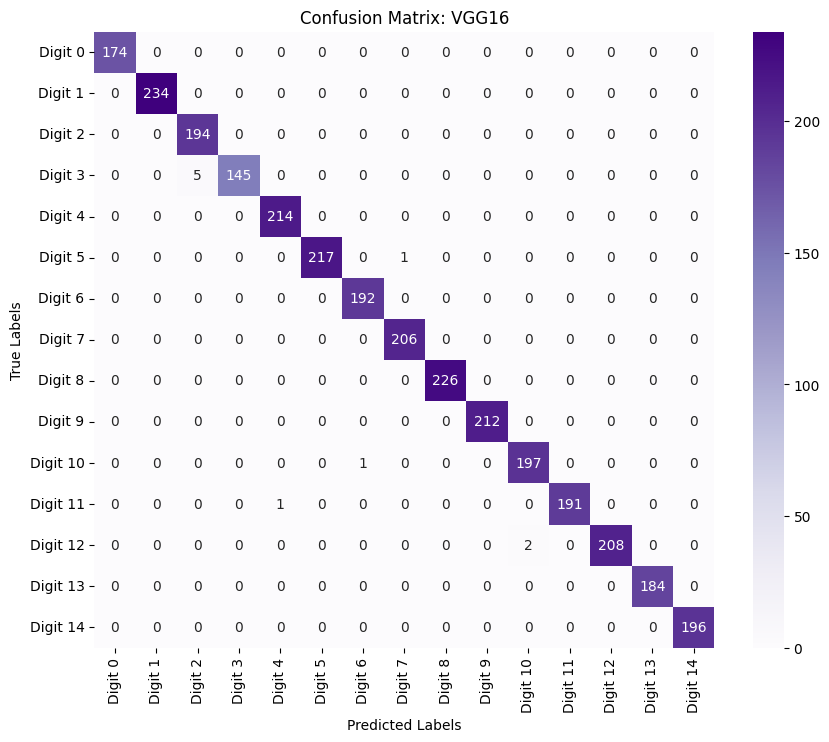

In [74]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.metrics import classification_report
class_names = [f"Digit {i}" for i in range(15)]
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
loaded_VGG16_model = loaded_VGG16_model.to(device)
model_name = "VGG16"
VGG16_overall_metrics, VGG16_per_class_metrics = evaluate_model_with_metrics(test_loader, loaded_VGG16_model, model_name, class_names, 'Purples')

## Lenet Evaluvation

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader

def train_and_select_best_model(train_loader, test_loader, model, criterion, optimizer, num_epochs, model_save_path='best_model.pth'):
    best_accuracy = 0.0
    best_model = None
    for epoch in range(num_epochs):
        model.train()
        epoch_loss = 0

        for X, y in train_loader:
            X, y = X.to(device), y.to(device)

            logits = model(X)
            loss = criterion(logits, y)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            epoch_loss += loss.item()

        accuracy = test_model_accuracy(test_loader, model)


        if accuracy > best_accuracy:
            best_accuracy = accuracy
            best_model = model

        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss}, Best Accuracy: {best_accuracy}%")

    if best_model is not None:
        torch.save(best_model.state_dict(), model_save_path)
        print(f"Best model saved at {model_save_path} with accuracy {best_accuracy}%")

    return best_model, best_accuracy
def test_model_accuracy(test_loader, model):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = 100 * correct / total
    print(f"Test Accuracy: {accuracy}%")
    return accuracy

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

params = {
    'batch_size': 64,
    'dropout_rate': 0.3,
    'learning_rate': 0.001,
    'num_epochs': 40,
    'optimizer': 'sgd'
}


model = LeNet(dropout_rate=params['dropout_rate']).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=params['learning_rate'], momentum=0.99)
train_loader = DataLoader(combined_trainDataset, batch_size=params['batch_size'], shuffle=True)
test_loader = DataLoader(combined_testDataset, batch_size=params['batch_size'], shuffle=False)


model, best_accuracy = train_and_select_best_model(train_loader, test_loader, model, criterion, optimizer, num_epochs=params['num_epochs'])


/tmp/ipykernel_43881/715621615.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('best_model.pth'))


Model: LeNet
Overall Accuracy: 97.27%

Classification Report:
               precision    recall  f1-score      support
Digit 0        1.000000  0.994253  0.997118   174.000000
Digit 1        0.991489  0.995726  0.993603   234.000000
Digit 2        0.950495  0.989691  0.969697   194.000000
Digit 3        0.993056  0.953333  0.972789   150.000000
Digit 4        0.972477  0.990654  0.981481   214.000000
Digit 5        0.990698  0.977064  0.983834   218.000000
Digit 6        0.989247  0.958333  0.973545   192.000000
Digit 7        0.985507  0.990291  0.987893   206.000000
Digit 8        0.965368  0.986726  0.975930   226.000000
Digit 9        0.940092  0.962264  0.951049   212.000000
Digit 10       0.916667  0.944444  0.930348   198.000000
Digit 11       0.989362  0.968750  0.978947   192.000000
Digit 12       0.974490  0.909524  0.940887   210.000000
Digit 13       0.983871  0.994565  0.989189   184.000000
Digit 14       0.959596  0.969388  0.964467   196.000000
accuracy       0.972667  

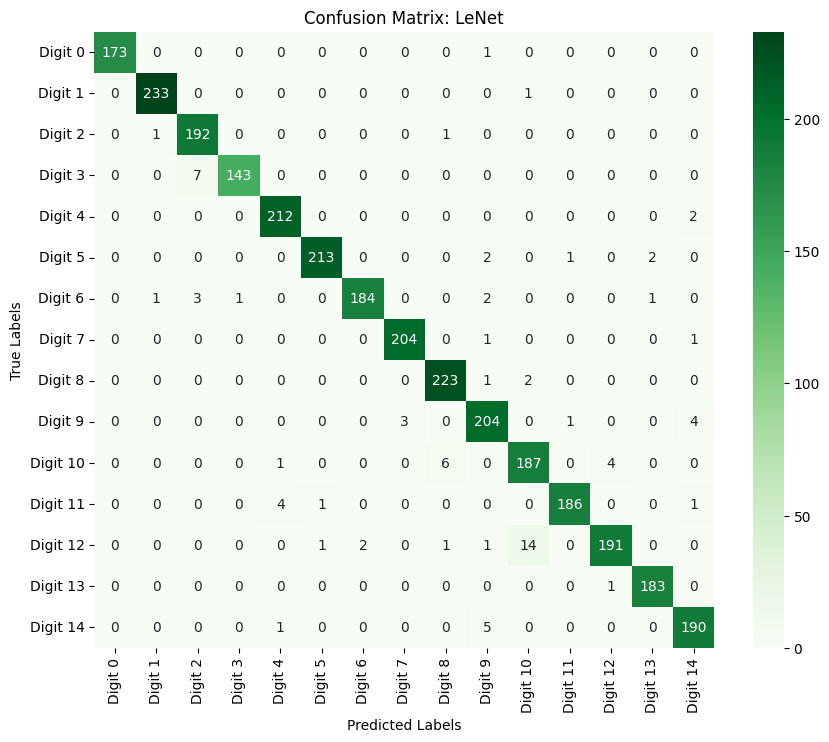

In [93]:
model.load_state_dict(torch.load('best_model.pth'))
model.eval()
class_names = [f"Digit {i}" for i in range(15)]  

model_name = "LeNet"
LeNet_overall_metrics, LeNet_per_class_metrics = evaluate_model_with_metrics(test_loader, model, model_name, class_names,"Greens")


## Resnet Evaluation


In [78]:
from torchvision import models

best_ResNet_model = ResNetWithDropout(dropout_rate = 0,num_classes=15, input_channels=1)

checkpoint = torch.load("./models/best_ResNet_weights.pth",map_location=torch.device('cpu'))
best_ResNet_model.load_state_dict(checkpoint)


best_ResNet_model.eval()  

/tmp/ipykernel_43881/1065266570.py:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load("./models/best_ResNet_weights.pth",map_location=torch.device('cpu

ResNetWithDropout(
  (resnet): ResNet(
    (conv1): Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, 

Model: ResNet
Overall Accuracy: 99.57%

Classification Report:
               precision    recall  f1-score      support
Digit 0        1.000000  0.994253  0.997118   174.000000
Digit 1        1.000000  0.995726  0.997859   234.000000
Digit 2        0.979798  1.000000  0.989796   194.000000
Digit 3        1.000000  0.973333  0.986486   150.000000
Digit 4        0.995349  1.000000  0.997669   214.000000
Digit 5        1.000000  0.995413  0.997701   218.000000
Digit 6        1.000000  1.000000  1.000000   192.000000
Digit 7        0.990385  1.000000  0.995169   206.000000
Digit 8        1.000000  0.995575  0.997783   226.000000
Digit 9        0.995283  0.995283  0.995283   212.000000
Digit 10       0.980198  1.000000  0.990000   198.000000
Digit 11       1.000000  0.989583  0.994764   192.000000
Digit 12       1.000000  0.990476  0.995215   210.000000
Digit 13       0.994595  1.000000  0.997290   184.000000
Digit 14       1.000000  1.000000  1.000000   196.000000
accuracy       0.995667 

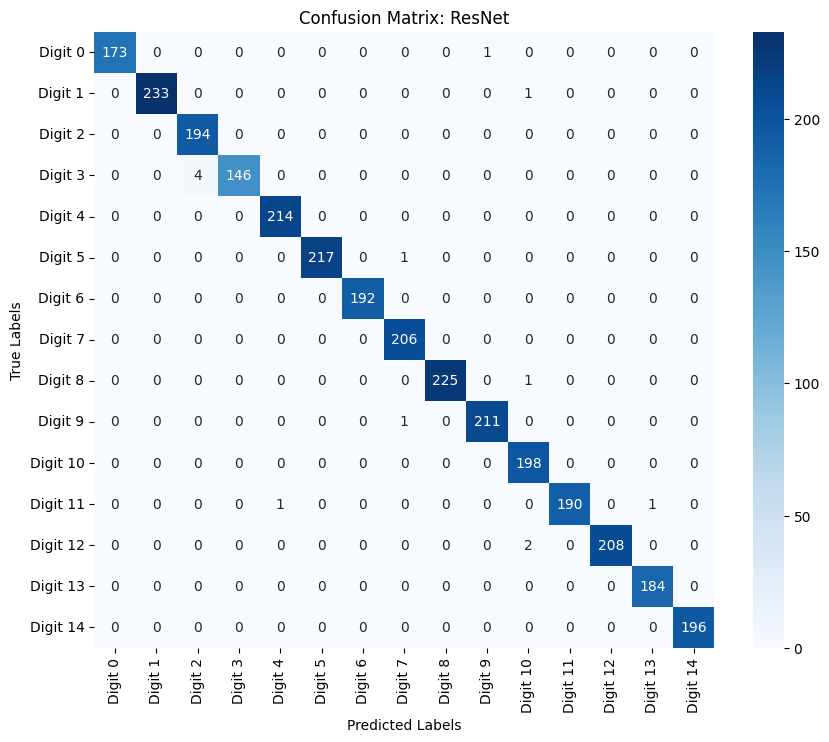

In [79]:
class_names = [f"Digit {i}" for i in range(15)] 
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
best_ResNet_model = best_ResNet_model.to(device)


model_name = "ResNet"
ResNet_overall_metrics, ResNet_per_class_metrics = evaluate_model_with_metrics(test_loader, best_ResNet_model, model_name, class_names, "Blues")

## Model Comparison

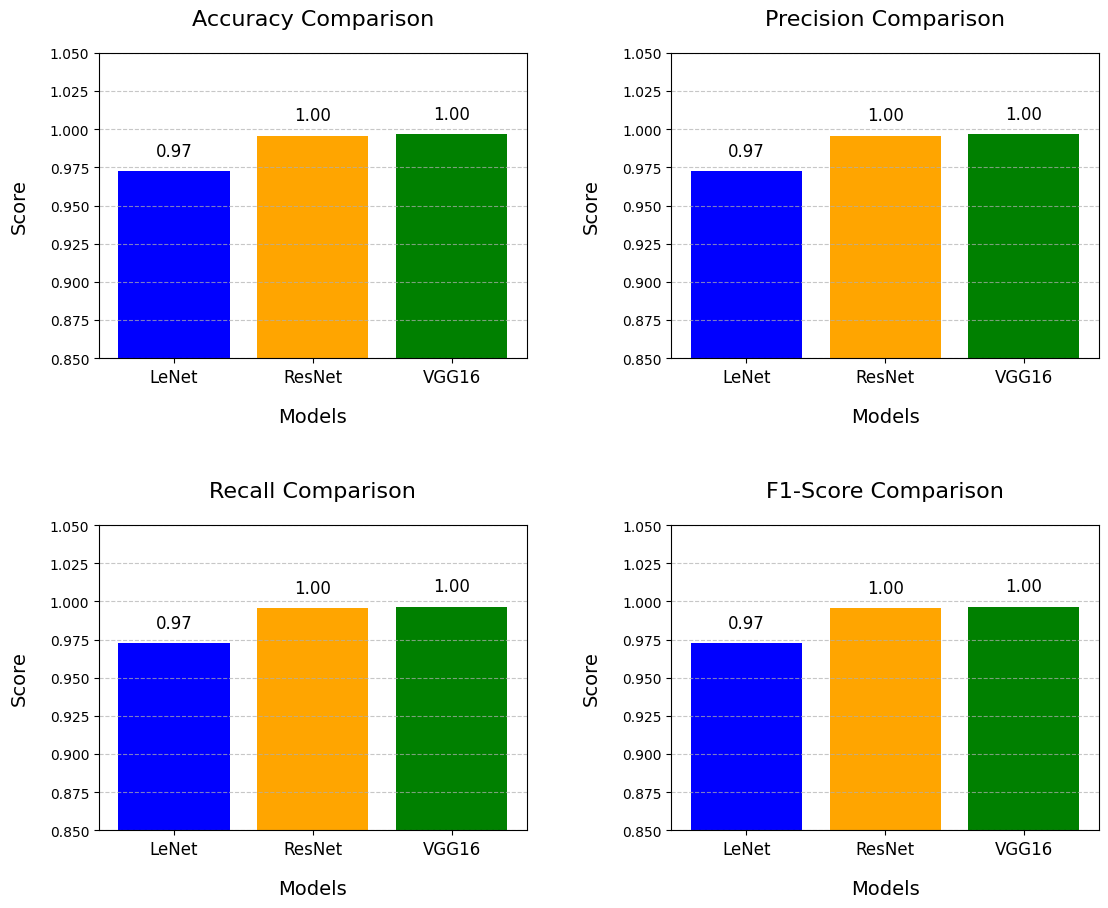

In [80]:
import matplotlib.pyplot as plt
import numpy as np

models = ["LeNet", "ResNet", "VGG16"]
accuracy = [
    LeNet_overall_metrics["accuracy"],
    ResNet_overall_metrics["accuracy"],
    VGG16_overall_metrics["accuracy"],
]
precision = [
    LeNet_overall_metrics["precision"],
    ResNet_overall_metrics["precision"],
    VGG16_overall_metrics["precision"],
]
recall = [
    LeNet_overall_metrics["recall"],
    ResNet_overall_metrics["recall"],
    VGG16_overall_metrics["recall"],
]
f1_score = [
    LeNet_overall_metrics["f1_score"],
    ResNet_overall_metrics["f1_score"],
    VGG16_overall_metrics["f1_score"],
]

metrics = {
    "Accuracy": accuracy,
    "Precision": precision,
    "Recall": recall,
    "F1-Score": f1_score,
}

colors = ["Blue", "Orange", "Green"]
fig, axes = plt.subplots(2, 2, figsize=(12, 10))
axes = axes.flatten()

def plot_metric(ax, metric_name, metric_values):
    x_pos = np.arange(len(models))
    ax.bar(x_pos, metric_values, color=colors)

    ax.set_title(f"{metric_name} Comparison", fontsize=16, pad=20)
    ax.set_xlabel('Models', fontsize=14, labelpad=15)
    ax.set_ylabel('Score', fontsize=14, labelpad=15)

    ax.set_xticks(x_pos)
    ax.set_xticklabels(models, fontsize=12)


    for i, v in enumerate(metric_values):
        ax.text(i, v + 0.01, f'{v:.2f}', ha='center', fontsize=12)

    ax.set_ylim(0.85, 1.05)
    ax.grid(axis='y', linestyle='--', alpha=0.7)


plot_metric(axes[0], "Accuracy", accuracy)
plot_metric(axes[1], "Precision", precision)
plot_metric(axes[2], "Recall", recall)
plot_metric(axes[3], "F1-Score", f1_score)

plt.tight_layout(pad=4.0)
plt.show()


## Metrics per class

/tmp/ipykernel_43881/2564633501.py:39: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(class_labels, rotation=45, ha="right")
/tmp/ipykernel_43881/2564633501.py:39: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(class_labels, rotation=45, ha="right")
/tmp/ipykernel_43881/2564633501.py:39: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(class_labels, rotation=45, ha="right")
/tmp/ipykernel_43881/2564633501.py:39: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(class_labels, rotation=45, ha="right")
/tmp/ipykernel_43881/2564633501.py:39: UserWarning: set_ticklabels() should only be used wit

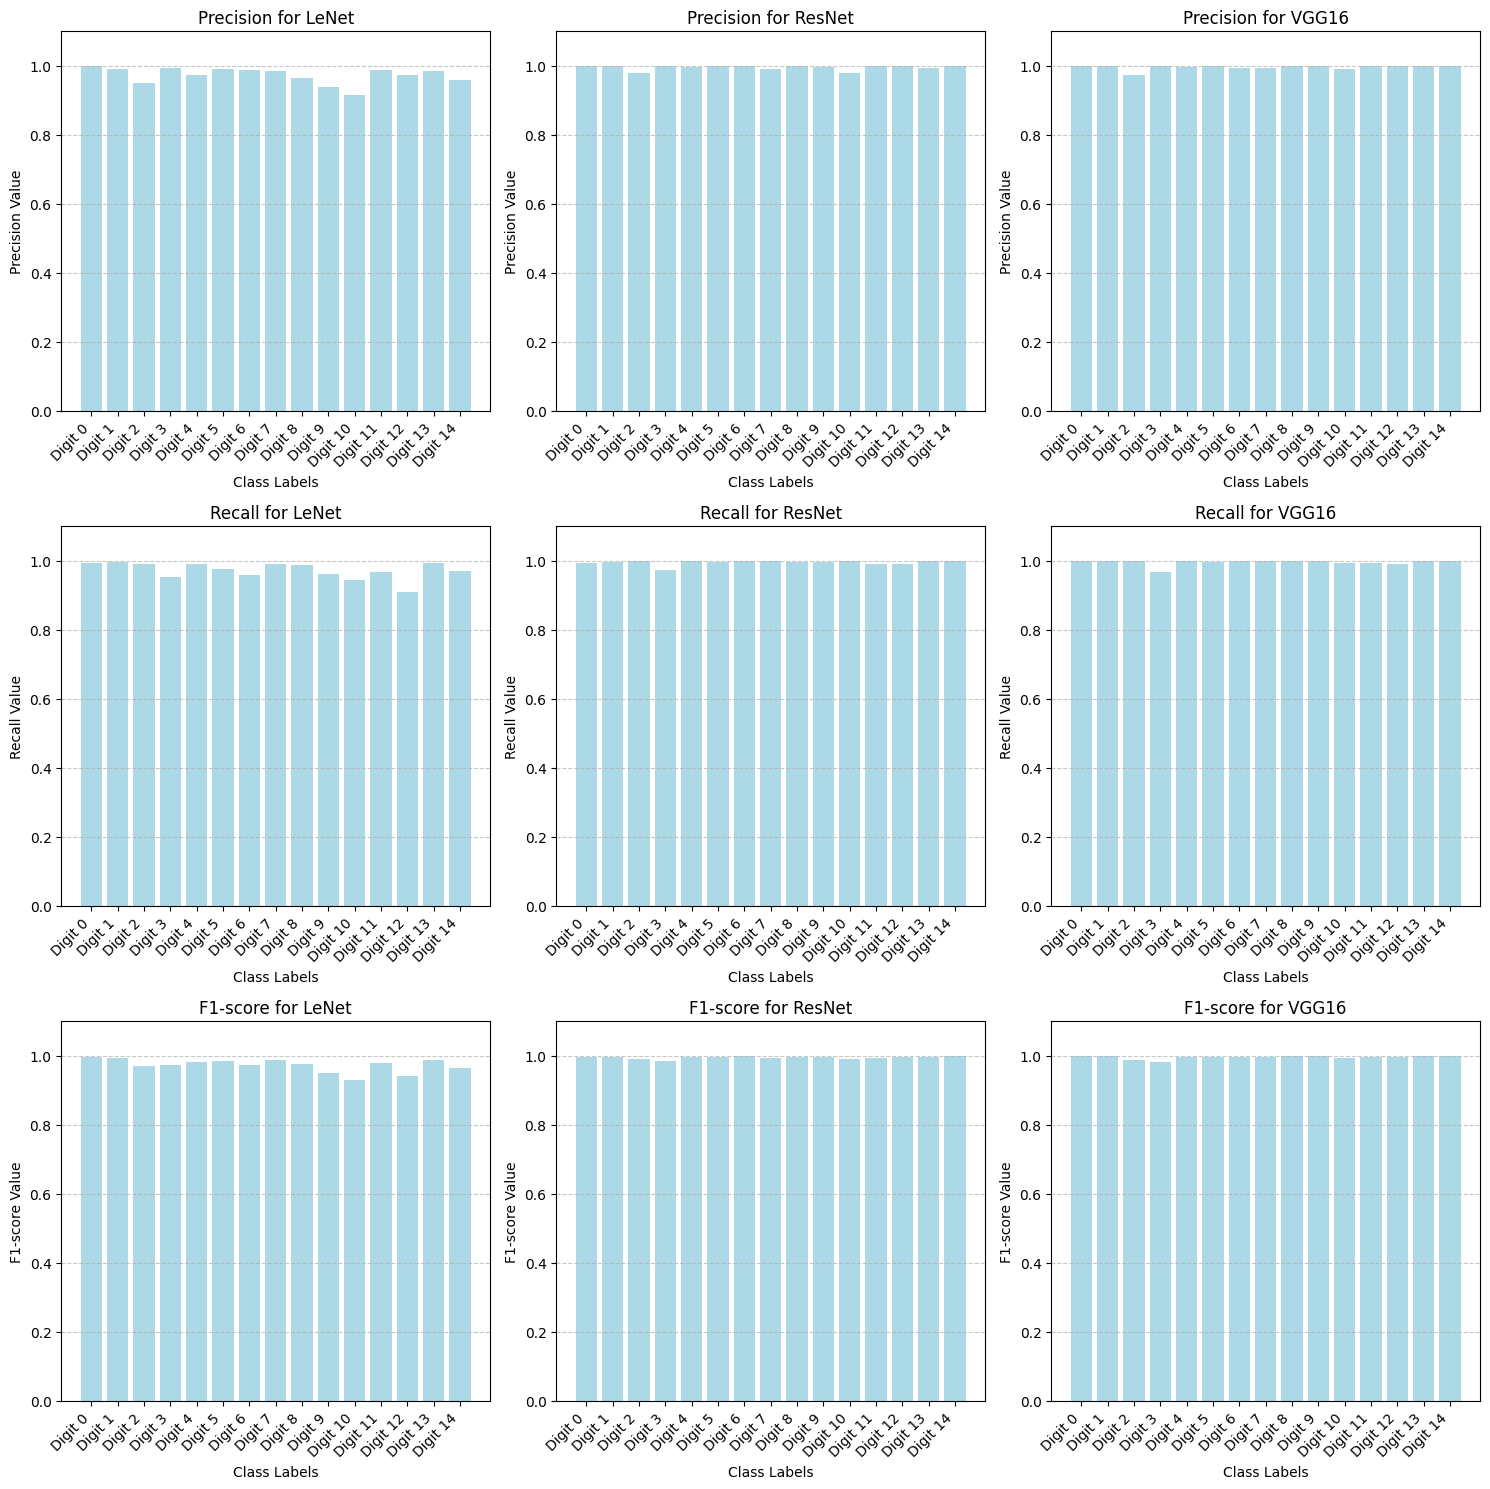

In [81]:
import matplotlib.pyplot as plt
import seaborn as sns


models = ["LeNet", "ResNet", "VGG16"]


fig, axes = plt.subplots(3, 3, figsize=(15, 15))
axes = axes.flatten()


metrics = ["precision", "recall", "f1-score"]


class_labels = list(LeNet_per_class_metrics.index)


for i, metric in enumerate(metrics):
    for j, model in enumerate(models):
        ax = axes[i * 3 + j]
        if model == "LeNet":
            metric_values = LeNet_per_class_metrics[metric]
        elif model == "ResNet":
            metric_values = ResNet_per_class_metrics[metric]
        else:
            metric_values = VGG16_per_class_metrics[metric]


        ax.bar(class_labels, metric_values, color="lightblue")


        ax.set_title(f"{metric.capitalize()} for {model}")
        ax.set_ylabel(f"{metric.capitalize()} Value")
        ax.set_xlabel("Class Labels")
        ax.set_ylim(0, 1.1)
        ax.grid(axis="y", linestyle="--", alpha=0.7)


        ax.set_xticklabels(class_labels, rotation=45, ha="right")

plt.tight_layout()
plt.show()


## ROC Plot

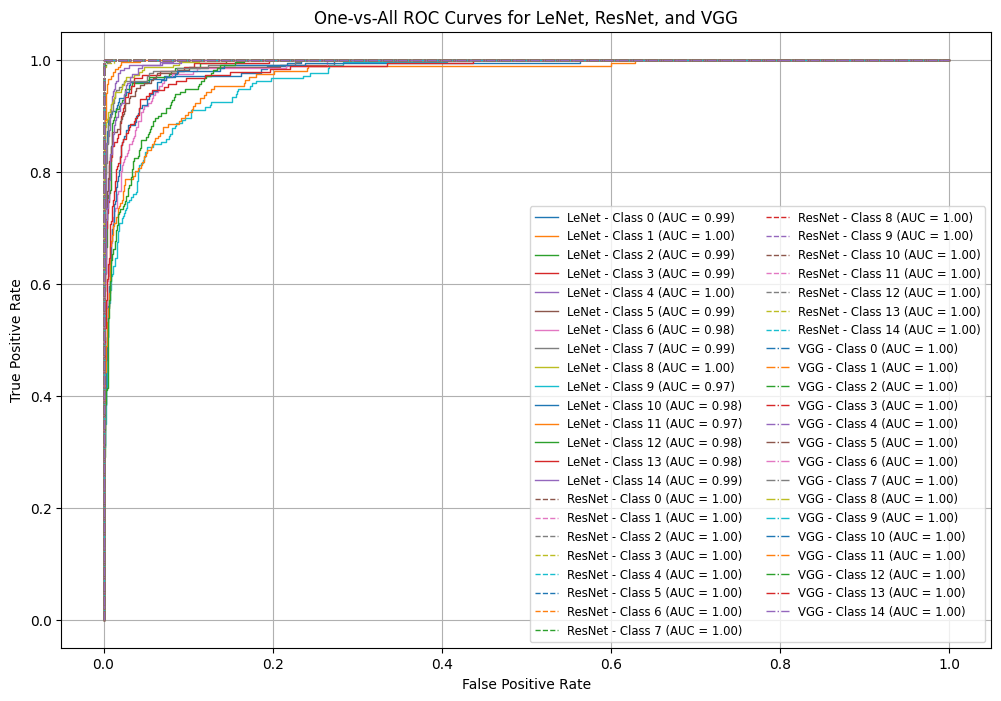

In [90]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt
import torch.nn.functional as F
from torchvision import models
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")



def compute_roc_curve_multiclass(model, dataloader, device, num_classes):
    model.eval()
    y_true = []
    y_pred = []


    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs = inputs.to(device)
            outputs = model(inputs)
            probs = F.softmax(outputs, dim=1)
            y_true.extend(labels.cpu().numpy())
            y_pred.extend(probs.cpu().numpy())


    y_true_bin = label_binarize(y_true, classes=range(num_classes))


    roc_curves = {}
    for i in range(num_classes):
        fpr, tpr, _ = roc_curve(y_true_bin[:, i], [p[i] for p in y_pred])
        roc_auc = auc(fpr, tpr)
        roc_curves[i] = (fpr, tpr, roc_auc)

    return roc_curves


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
num_classes = 15


roc_curves_lenet = compute_roc_curve_multiclass(model, test_loader, device, num_classes)
roc_curves_resnet = compute_roc_curve_multiclass(best_ResNet_model, test_loader, device, num_classes)
loaded_VGG16_model = loaded_VGG16_model.to(device)
roc_curves_vgg = compute_roc_curve_multiclass(loaded_VGG16_model, test_loader, device, num_classes)


plt.figure(figsize=(12, 8))

# LeNet
for i, (fpr, tpr, auc_score) in roc_curves_lenet.items():
    plt.plot(fpr, tpr, lw=1, label=f'LeNet - Class {i} (AUC = {auc_score:.2f})')

# ResNet
for i, (fpr, tpr, auc_score) in roc_curves_resnet.items():
    plt.plot(fpr, tpr, '--', lw=1, label=f'ResNet - Class {i} (AUC = {auc_score:.2f})')

# VGG
for i, (fpr, tpr, auc_score) in roc_curves_vgg.items():
    plt.plot(fpr, tpr, '-.', lw=1, label=f'VGG - Class {i} (AUC = {auc_score:.2f})')

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('One-vs-All ROC Curves for LeNet, ResNet, and VGG')
plt.legend(loc='lower right', fontsize='small', ncol=2)
plt.grid()
plt.show()


## Precision and Recall Curve

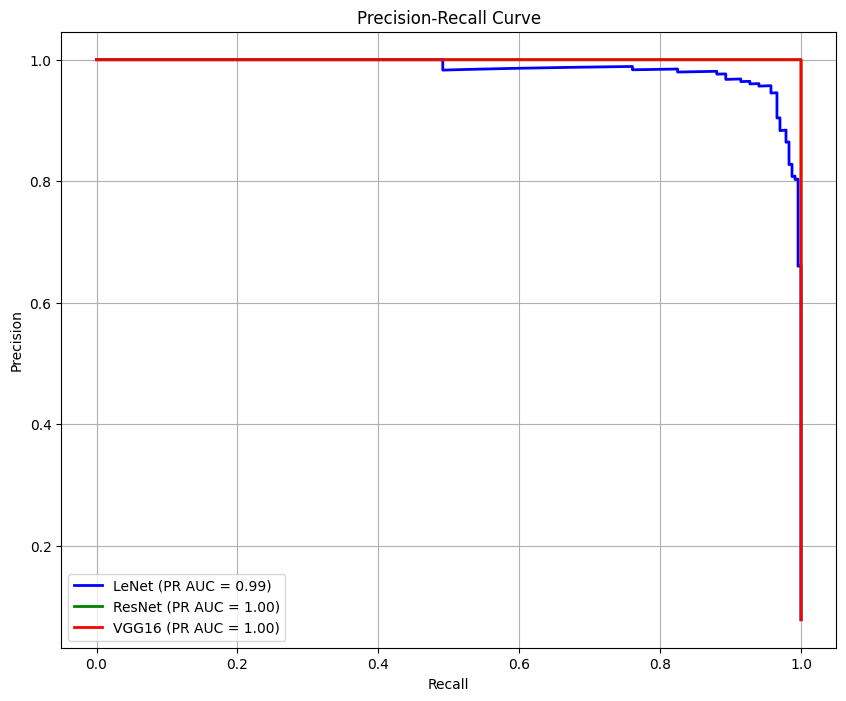

In [91]:
from sklearn.metrics import precision_recall_curve, auc
import matplotlib.pyplot as plt

def compute_precision_recall_curve(model, dataloader, device, num_classes=15):
    model.eval()
    y_true = []
    y_pred = []

    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)


            outputs = model(inputs)
            probs = F.softmax(outputs, dim=1).cpu().numpy()


            y_true.extend(labels.cpu().numpy())
            y_pred.extend(probs)


    y_true_binarized = label_binarize(y_true, classes=range(num_classes))
    precision = {}
    recall = {}
    pr_auc = {}

    for i in range(num_classes):
        precision[i], recall[i], _ = precision_recall_curve(y_true_binarized[:, i], [pred[i] for pred in y_pred])
        pr_auc[i] = auc(recall[i], precision[i])

    return precision, recall, pr_auc
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

plt.figure(figsize=(10, 8))


precision1, recall1, pr_auc1 = compute_precision_recall_curve(model, test_loader, device)
plt.plot(recall1[1], precision1[1], color='blue', lw=2, label=f'LeNet (PR AUC = {pr_auc1[1]:.2f})')


precision2, recall2, pr_auc2 = compute_precision_recall_curve(best_ResNet_model, test_loader, device)
plt.plot(recall2[1], precision2[1], color='green', lw=2, label=f'ResNet (PR AUC = {pr_auc2[1]:.2f})')


precision3, recall3, pr_auc3 = compute_precision_recall_curve(loaded_VGG16_model, test_loader, device)
plt.plot(recall3[1], precision3[1], color='red', lw=2, label=f'VGG16 (PR AUC = {pr_auc3[1]:.2f})')


plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend()
plt.grid()
plt.show()



## Showing results in a table

In [92]:
import pandas as pd

models = ["LeNet", "ResNet", "VGG16"]

accuracy = [
    LeNet_overall_metrics["accuracy"],
    ResNet_overall_metrics["accuracy"],
    VGG16_overall_metrics["accuracy"],
]
precision = [
    LeNet_overall_metrics["precision"],
    ResNet_overall_metrics["precision"],
    VGG16_overall_metrics["precision"],
]
recall = [
    LeNet_overall_metrics["recall"],
    ResNet_overall_metrics["recall"],
    VGG16_overall_metrics["recall"],
]
f1_score = [
    LeNet_overall_metrics["f1_score"],
    ResNet_overall_metrics["f1_score"],
    VGG16_overall_metrics["f1_score"],
]

df = pd.DataFrame({
    "Model": models,
    "Accuracy (%)": accuracy,
    "Precision (%)": precision,
    "Recall (%)": recall,
    "F1-Score (%)": f1_score
})

print(df)
print(LeNet_overall_metrics["f1_score"])
print(LeNet_overall_metrics)
print(ResNet_overall_metrics)

    Model  Accuracy (%)  Precision (%)  Recall (%)  F1-Score (%)
0   LeNet      0.972667       0.972667    0.972667      0.972667
1  ResNet      0.995667       0.995667    0.995667      0.995667
2   VGG16      0.996667       0.996667    0.996667      0.996667
0.9726666666666667
{'model_name': 'LeNet', 'accuracy': 0.9726666666666667, 'precision': np.float64(0.9726666666666667), 'recall': np.float64(0.9726666666666667), 'f1_score': np.float64(0.9726666666666667)}
{'model_name': 'ResNet', 'accuracy': 0.9956666666666667, 'precision': np.float64(0.9956666666666667), 'recall': np.float64(0.9956666666666667), 'f1_score': np.float64(0.9956666666666667)}
